# Rollout rgb_ppo ONNX in MuJoCo (AirbotPlayPickCube)

This notebook runs an exported **rgb_ppo** policy (ONNX) inside a MuJoCo XML (`mjx_single_cube.xml`) and records a video.

**Default run directory:** `/data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/rgbppo_AirbotPlayPickCube__1__1766164466`

Notes:
- The notebook **auto-detects ONNX input signature**:
  - vector obs: `(B, D)`
  - image-only: `(B, H, W, C)` or `(B, C, H, W)`
  - image+state: two inputs (one 4D image tensor + one 2D state tensor)
- For **pure-vision**, you should export a **rgb-only** ONNX (no `state` input). If your ONNX expects `state`, this notebook can feed zeros by default, but that usually degrades performance unless your `state` matches training.


In [ ]:
import os
# --- Paths (edit if needed) ---
RUN_DIR = r"/data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/pickcube_reward_r1_50m"
XML_PATH = r"/data/user/junzhe/code/mjpl/mujoco_playground/mujoco_playground/_src/manipulation/airbot_play/xmls/mjx_single_cube.xml"

# Pick ONE of these (prefer rgb-only for "pure vision"):
ONNX_RGB_ONLY = os.path.join(RUN_DIR, "policy_rgb.onnx")
ONNX_RGB_STATE = os.path.join(RUN_DIR, "policy_rgb_state.onnx")

ONNX_PATH = ONNX_RGB_ONLY if os.path.exists(ONNX_RGB_ONLY) else ONNX_RGB_STATE
print("Using ONNX_PATH =", ONNX_PATH)


Using ONNX_PATH = /data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/home_key_rgb_ppo_1224/policy_rgb_state.onnx


In [2]:
# IMPORTANT: set MUJOCO_GL before importing mujoco
import os
os.environ.setdefault("MUJOCO_GL", "egl")

import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=200)

import mujoco
import mediapy
import onnxruntime as ort
from PIL import Image


## Inspect ONNX inputs/outputs

In [3]:
assert os.path.exists(XML_PATH), f"XML not found: {XML_PATH}"
assert os.path.exists(ONNX_PATH), f"ONNX not found: {ONNX_PATH}"

sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
print("Outputs:")
for o in sess.get_outputs():
    print(" ", o.name, o.shape, o.type)
print("Inputs:")
for i in sess.get_inputs():
    print(" ", i.name, i.shape, i.type)

inputs = sess.get_inputs()
outputs = sess.get_outputs()
out_name = outputs[0].name


Outputs:
  action ['batch', 7] tensor(float)
Inputs:
  rgb ['batch', 128, 128, 3] tensor(uint8)
  state ['batch', 50] tensor(float)


## Helpers: resize/render + ONNX feed

In [4]:
def _shape_len(x):
    try:
        return len(x)
    except Exception:
        return None

def _is_image_shape(shape):
    # Accept common 4D forms: (B,H,W,C) or (B,C,H,W)
    return _shape_len(shape) == 4

def _is_vector_shape(shape):
    return _shape_len(shape) == 2

def _infer_io_layout(input_info):
    """Return dict describing expected inputs."""
    infos = [{"name": i.name, "shape": i.shape, "type": i.type} for i in input_info]
    image_inputs = [x for x in infos if _is_image_shape(x["shape"])]
    vec_inputs = [x for x in infos if _is_vector_shape(x["shape"])]

    layout = {"mode": None, "image": None, "state": None, "vector": None}
    if len(infos) == 1 and image_inputs:
        layout["mode"] = "image_only"
        layout["image"] = image_inputs[0]
    elif len(infos) == 2 and len(image_inputs) == 1 and len(vec_inputs) == 1:
        layout["mode"] = "image_state"
        layout["image"] = image_inputs[0]
        layout["state"] = vec_inputs[0]
    elif len(infos) == 1 and vec_inputs:
        layout["mode"] = "vector_only"
        layout["vector"] = vec_inputs[0]
    else:
        layout["mode"] = "unknown"
    return layout

layout = _infer_io_layout(inputs)
print("Detected ONNX layout:", layout["mode"])


Detected ONNX layout: image_state


In [5]:
def render_rgb(renderer: mujoco.Renderer, data: mujoco.MjData, camera: str) -> np.ndarray:
    """Return RGB uint8 image in HWC."""
    renderer.update_scene(data, camera=camera)
    img = renderer.render()
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def resize_hwc_uint8(img: np.ndarray, H: int, W: int) -> np.ndarray:
    """Resize HWC uint8 to (H,W,3)."""
    pil = Image.fromarray(img)
    pil = pil.resize((W, H), resample=Image.BILINEAR)
    out = np.asarray(pil, dtype=np.uint8)
    if out.ndim == 2:
        out = np.repeat(out[..., None], 3, axis=2)
    if out.shape[-1] == 4:
        out = out[..., :3]
    return out

def to_onnx_image(img_hwc_u8: np.ndarray, image_input) -> np.ndarray:
    """Pack image into expected ONNX image tensor (batch included)."""
    shape = image_input["shape"]  # e.g., [None, H, W, 3] or [None, 3, H, W]
    typ = image_input["type"]

    # Determine expected H/W/C positions
    # If second dim is 3, assume NCHW; else assume NHWC.
    is_nchw = (shape[1] == 3) if (len(shape) == 4 and isinstance(shape[1], int)) else False

    x = img_hwc_u8
    if is_nchw:
        x = np.transpose(x, (2, 0, 1))  # CHW
    x = x[None, ...]  # add batch

    # Cast based on input type
    if "uint8" in typ:
        return x.astype(np.uint8)
    else:
        # Most exported graphs cast to float internally anyway; float32 is safe.
        return x.astype(np.float32)

def to_onnx_state(state_vec: np.ndarray, state_input) -> np.ndarray:
    typ = state_input["type"]
    x = state_vec[None, :]
    if "float" in typ:
        return x.astype(np.float32)
    return x.astype(np.float32)


## (Optional) Vector obs builder
Only used if your ONNX was accidentally exported as a vector-only policy.

In [6]:
_ARM_JOINTS = ["joint1", "joint2", "joint3", "joint4", "joint5", "joint6"]
_FINGER_JOINTS = ["endleft", "endright"]

def build_vector_obs(model: mujoco.MjModel, data: mujoco.MjData) -> np.ndarray:
    """A best-effort vector obs (may NOT match training)."""
    gripper_site_id = model.site("endpoint").id
    obj_body_id = model.body("box").id

    # Joint indices
    all_joints = _ARM_JOINTS + _FINGER_JOINTS
    robot_qpos_adr = np.array([model.jnt_qposadr[model.joint(j).id] for j in all_joints])

    gripper_pos = data.site_xpos[gripper_site_id]
    gripper_mat = data.site_xmat[gripper_site_id].reshape(9)

    obj_xmat = data.xmat[obj_body_id].reshape(9)
    obj_xpos = data.xpos[obj_body_id]

    # WARNING: This likely differs from your MJX training obs. Use only if your ONNX is vector-only.
    obs = np.concatenate([
        data.qpos[robot_qpos_adr],
        data.qvel[robot_qpos_adr],
        gripper_pos,
        gripper_mat,
        obj_xmat,
        obj_xpos - gripper_pos,
    ]).astype(np.float32)
    return obs


## Rollout

In [ ]:
# Load MuJoCo model
model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)

# Render setup (visualization only; policy input will be resized as needed)
# cameras = ["side", "front"]
cameras = ["side"]
vis_h, vis_w = 480, 640
renderer = mujoco.Renderer(model, height=vis_h, width=vis_w)

# Control/sim timing
ctrl_dt = 0.02
sim_dt = 0.005
n_substeps = int(round(ctrl_dt / sim_dt))
model.opt.timestep = sim_dt

# Action scaling (delta-ctrl style). Keep consistent with training if possible.
action_scale = 0.04

# Actuator ctrl range
ctrl_range = model.actuator_ctrlrange.copy()

# Helper: render one camera (RGB uint8)
def _render_cam(cam_name, h, w):
    renderer.update_scene(data, camera=cam_name)
    img = renderer.render()  # (H,W,3) uint8
    if img.shape[0] != h or img.shape[1] != w:
        img = np.asarray(Image.fromarray(img).resize((w, h), resample=Image.BILINEAR))
    return img

# Determine policy image size if needed
policy_h = None
policy_w = None
if layout["mode"] in ("image_only", "image_state"):
    img_in = layout["image"]
    sh = img_in["shape"]
    # Typical 4D: (B,C,H,W) or (B,H,W,C). Some exports may have dynamic dims.
    if len(sh) == 4:
        if sh[1] == 3:  # NCHW
            policy_h = int(sh[2]) if isinstance(sh[2], int) else vis_h
            policy_w = int(sh[3]) if isinstance(sh[3], int) else vis_w
        else:  # NHWC
            policy_h = int(sh[1]) if isinstance(sh[1], int) else vis_h
            policy_w = int(sh[2]) if isinstance(sh[2], int) else vis_w
    else:
        policy_h, policy_w = vis_h, vis_w

# Multi-view policy input: horizontally concat cameras into one wide image
# NOTE: If your training uses a different fusion (e.g., channel concat), change here.
def render_multi_view_input():
    if layout["mode"] not in ("image_only", "image_state"):
        raise RuntimeError("render_multi_view_input called but policy is not image-based")
    h = policy_h or vis_h
    w = policy_w or vis_w

    # Render each view at (h,w) then concat along width
    imgs = [_render_cam(cam, h, w) for cam in cameras]
    if len(imgs) == 1:
        return imgs[0]
    return np.concatenate(imgs, axis=2)  # (h, w*V, 3)

# For visualization video: use vis_h/vis_w and concat too
def render_multi_view_vis():
    imgs = [_render_cam(cam, vis_h, vis_w) for cam in cameras]
    if len(imgs) == 1:
        return imgs[0]
    return np.concatenate(imgs, axis=1)

# Resolve state dim if needed (rgb+state)
state_dim = None
if layout["mode"] == "image_state":
    st = layout["state"]["shape"]
    # st is typically (B, D)
    if len(st) == 2 and isinstance(st[1], int):
        state_dim = int(st[1])
    else:
        raise RuntimeError(f"Cannot infer state dim from {st}. Please hardcode state_dim.")

def policy_step():
    """Compute action from current sim state."""
    feed = {}
    if layout["mode"] == "image_only":
        img_rs = render_multi_view_input()
        feed[layout["image"]["name"]] = to_onnx_image(img_rs, layout["image"])
    elif layout["mode"] == "image_state":
        img_rs = render_multi_view_input()
        feed[layout["image"]["name"]] = to_onnx_image(img_rs, layout["image"])

        # Default: feed zeros. Replace this with a training-consistent state vector if you trained with state.
        state = np.zeros((state_dim,), dtype=np.float32)
        feed[layout["state"]["name"]] = to_onnx_state(state, layout["state"])
    elif layout["mode"] == "vector_only":
        obs = build_vector_obs(model, data)
        feed[layout["vector"]["name"]] = obs[None, :].astype(np.float32)
    else:
        raise RuntimeError("Unknown ONNX input layout; cannot run. Check sess.get_inputs().")

    action = sess.run([out_name], feed)[0][0].astype(np.float32)
    return action

# ---- Debug: indices for robot joints and gripper actuator ----
all_joints = _ARM_JOINTS + _FINGER_JOINTS
robot_qpos_adr = np.array([model.jnt_qposadr[model.joint(j).id] for j in all_joints])

gripper_act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "gripper")
if gripper_act_id >= 0:
    print("Found actuator 'gripper' id =", gripper_act_id)

# Reset to home keyframe if available
mujoco.mj_resetData(model, data)
key_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_KEY, "home")
if key_id >= 0:
    mujoco.mj_resetDataKeyframe(model, data, key_id)
    # If keyframe ctrl exists, set ctrl; otherwise keep default
    try:
        data.ctrl[:] = model.keyframe("home").ctrl
    except Exception:
        pass
else:
    print("Keyframe 'home' not found; using default reset state.")

# ---- Rollout ----
fps = 25
horizon_seconds = 3.0
horizon_steps = int(round(horizon_seconds / ctrl_dt))

frames = []
log_history = []  # each entry stores time, action, ctrl, qpos, qvel (and gripper signals)

for step in range(horizon_steps):
    # Render for video (optional)
    img_vis = render_multi_view_vis()

    # Policy inference
    action = policy_step()

    # Apply action as delta to ctrl
    if action.size != data.ctrl.size:
        raise RuntimeError(
            f"action dim {action.size} != ctrl dim {data.ctrl.size}. "
            "Your ONNX likely targets a different action space/control mode."
        )

    ctrl_before = data.ctrl.copy()
    data.ctrl[:] = np.clip(data.ctrl + action_scale * action, ctrl_range[:, 0], ctrl_range[:, 1])
    ctrl_after = data.ctrl.copy()

    # Step physics
    for _ in range(n_substeps):
        mujoco.mj_step(model, data)

    # Sample video
    if len(frames) < int(data.time * fps):
        frames.append(img_vis)

    # Log
    entry = {
        "time": float(data.time),
        "step": int(step),
        "action": action.copy(),
        "ctrl_before": ctrl_before,
        "ctrl_after": ctrl_after,
        "qpos": data.qpos.copy(),
        "qvel": data.qvel.copy(),
        "robot_qpos": data.qpos[robot_qpos_adr].copy(),
        "robot_qvel": data.qvel[robot_qpos_adr].copy(),
    }
    if gripper_act_id >= 0:
        entry["ctrl_gripper"] = float(ctrl_after[gripper_act_id])
    # Finger joints (if names exist)
    for jname in _FINGER_JOINTS:
        try:
            jid = model.joint(jname).id
            qadr = int(model.jnt_qposadr[jid])
            entry[f"qpos_{jname}"] = float(data.qpos[qadr])
        except Exception:
            pass
    log_history.append(entry)

print("Collected frames:", len(frames), " | Logged steps:", len(log_history))
mediapy.show_video(frames, fps=fps)


Found actuator 'gripper' id = 6
Collected frames: 74  | Logged steps: 150


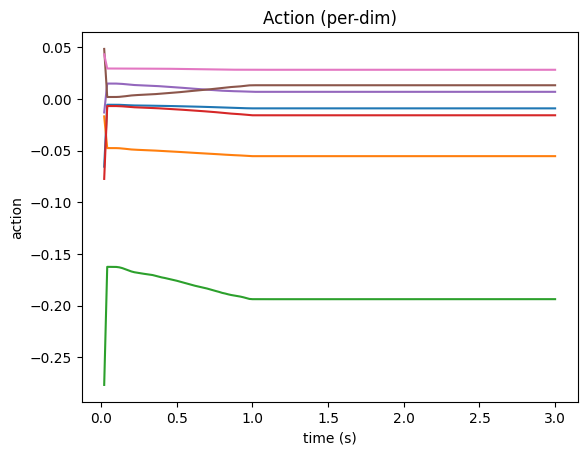

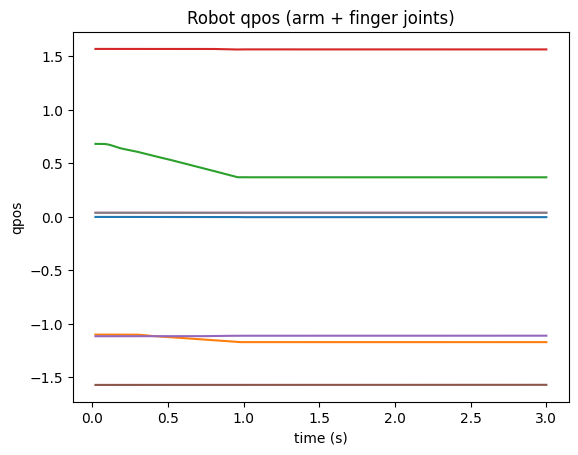

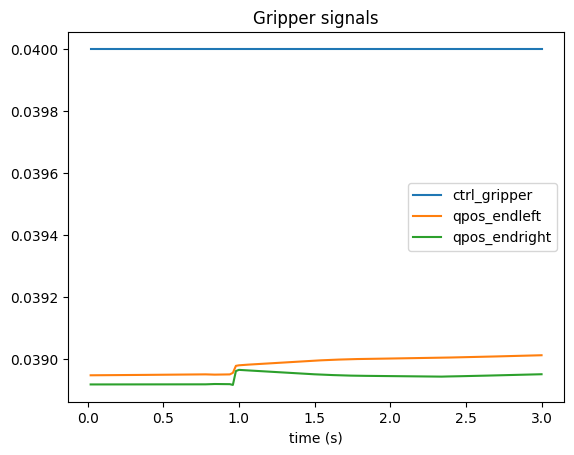

Wrote: /data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/home_key_rgb_ppo_1224/debug_rollout_signals.csv rows: 150


,time,step,ctrl_gripper,action_0,action_1,action_2,action_3,action_4,action_5,action_6,robot_qpos_0,robot_qpos_1,robot_qpos_2,robot_qpos_3,robot_qpos_4,robot_qpos_5,robot_qpos_6,robot_qpos_7
0,0.02,0,0.04,-0.065570,-0.016930,-0.276669,-0.077415,-0.013137,0.048318,0.043045,-0.000008,-1.100125,0.682989,1.570799,-1.115500,-1.5708,0.038948,0.038919
1,0.04,1,0.04,-0.005671,-0.047599,-0.162460,-0.006931,0.014810,0.001815,0.029378,-0.000019,-1.100330,0.682976,1.570799,-1.115500,-1.5708,0.038948,0.038919
2,0.06,2,0.04,-0.005671,-0.047600,-0.162460,-0.006929,0.014809,0.001812,0.029379,-0.000032,-1.100591,0.682960,1.570798,-1.115499,-1.5708,0.038949,0.038919
3,0.08,3,0.04,-0.005674,-0.047609,-0.162487,-0.006934,0.014800,0.001818,0.029376,-0.000042,-1.100683,0.681942,1.570798,-1.115511,-1.5708,0.038949,0.038919
4,0.10,4,0.04,-0.005685,-0.047631,-0.162559,-0.006950,0.014785,0.001839,0.029375,-0.000053,-1.100726,0.678311,1.570798,-1.115536,-1.5708,0.038949,0.038919


In [9]:
# ---- Plot actions / gripper / joint angles (debug) ----
import matplotlib.pyplot as plt

# Clip for readability
log_history_clip = log_history[:300]

times = np.array([e["time"] for e in log_history_clip])
actions = np.stack([e["action"] for e in log_history_clip], axis=0)
robot_qpos = np.stack([e["robot_qpos"] for e in log_history_clip], axis=0)
ctrl_after = np.stack([e["ctrl_after"] for e in log_history_clip], axis=0)

# 1) Action curves
plt.figure()
plt.plot(times, actions)
plt.title("Action (per-dim)")
plt.xlabel("time (s)")
plt.ylabel("action")
plt.show()

# 2) Robot qpos (arm + finger joints)
plt.figure()
plt.plot(times, robot_qpos)
plt.title("Robot qpos (arm + finger joints)")
plt.xlabel("time (s)")
plt.ylabel("qpos")
plt.show()

# 3) Gripper command / finger joint angles (if available)
plt.figure()
if "ctrl_gripper" in log_history_clip[0]:
    gripper_ctrl = np.array([e.get("ctrl_gripper", np.nan) for e in log_history_clip], dtype=np.float32)
    plt.plot(times, gripper_ctrl, label="ctrl_gripper")
for jname in _FINGER_JOINTS:
    key = f"qpos_{jname}"
    if key in log_history_clip[0]:
        vals = np.array([e.get(key, np.nan) for e in log_history_clip], dtype=np.float32)
        plt.plot(times, vals, label=key)
plt.title("Gripper signals")
plt.xlabel("time (s)")
plt.legend()
plt.show()

# Optional: dump to CSV for offline inspection
import pandas as pd
rows = []
for e in log_history:
    row = {"time": e["time"], "step": e["step"]}
    for k in ["ctrl_gripper"]:
        if k in e: row[k] = e[k]
    # Flatten action dims
    for i, v in enumerate(e["action"].tolist()):
        row[f"action_{i}"] = v
    # Flatten robot qpos dims
    for i, v in enumerate(e["robot_qpos"].tolist()):
        row[f"robot_qpos_{i}"] = v
    rows.append(row)

df = pd.DataFrame(rows)
csv_path = os.path.join(os.path.dirname(ONNX_PATH), "debug_rollout_signals.csv")
df.to_csv(csv_path, index=False)
print("Wrote:", csv_path, "rows:", len(df))
df.head()


## Save MP4 (optional)

In [30]:
import imageio.v2 as imageio
out_mp4 = os.path.join(r"/data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/rgbppo_AirbotPlayPickCube__1__1766164466", "onnx_rollout.mp4")
imageio.mimwrite(out_mp4, frames, fps=30, codec="libx264", quality=8)
print("Wrote:", out_mp4)


Wrote: /data/user/junzhe/code/mjpl/mujoco_playground/learning/runs/rgbppo_AirbotPlayPickCube__1__1766164466/onnx_rollout.mp4


    ## If your ONNX expects `state`

    For **rgb+state** ONNX, you must feed a `state` vector that matches training.
    If you exported `policy_rgb_state.onnx` from your MJX wrapper training, the correct `state` is whatever your MJX env provided as `obs["state"]`.
    Running the same ONNX inside a standalone MuJoCo XML without reproducing that state definition will usually reduce performance.

    If you want **pure-vision** inference, re-export **rgb-only** ONNX and use it here.
    